In [1]:
# Scientific core 
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  

# Model selection 
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, validation_curve

# Pipelines & preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Models 
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso, LassoCV,
)

# Feature selection 
from sklearn.feature_selection import SelectFromModel

# Metrics 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer


In [2]:
# Load the dataset
df = pd.read_csv("data/Walmart_Store_sales.csv")

### I. Analyse exploratoire des données

In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include="all")
display(data_desc)
print()

print("Percentage of missing values: ")
display(100 * df.isnull().sum() / df.shape[0])

df.info()

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Dimension et structure du dataset
</span></center>
</br>
<div style="font-size:85%">

- Le dataset contient 150 lignes et 8 colonnes (=> peu de données).
- Les variables disponibles sont:
    - Store: identifiant des magasins (1 à 20) - variable catégorielle nominale discrète
    - Date: variable temporelle
    - Weekly_Sales: ventes hebdomadaires (en dollars) - variable numérique continue
        - moyenne: 1.25 M$
        - min: 0.27 M$, max: 2.77 M$
        - Grande variabilité - cela indique une forte disparité des ventes selon les magasins et/ou périodes
    - Holiday_Flag: indicateur binaire (1 si jour férié, 0 sinon) - variable catégorielle binaire - peu de valeurs à 1 
    - Temperature: température moyenne (°F) - variable numérique continue
    - Fuel_Price: prix moyen du carburant (dollars) - variable numérique continue
    - CPI: Consumer Price Index (indice des prix à la consommation) - variable numérique continue
    - Unemployment: taux de chômage (en %) - variable numérique continue
</div>

<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Valeurs manquantes
</span></center>
</br>
<div style="font-size:85%">

- Date et Temperature: 12%
- Weekly_Sales et Fuel_Price: 9.33%
- Holiday_Flag et CPI: 8%
- Unemployment: 10%
</div>

<div style="font-size:85%">

- Target quantitative (Weekly_Sales) => régression
- Objectif : Prédire les ventes hebdomadaires 
</dib>

#### a. Nettoyage initial et gestion des dates 

In [4]:
# Exclude rows where the target variable (Y) 'Weekly_Sales' is missing
# .notna() keeps only rows where 'Weekly_Sales' is NOT null
df_clean = df[df['Weekly_Sales'].notna()].copy()
len(df_clean)

136

In [5]:
# Convert the 'Date' column to datetime format (with day first)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], dayfirst=True)

# Extract date features
df_clean['year'] = df_clean['Date'].dt.year
df_clean['month'] = df_clean['Date'].dt.month
df_clean['day_of_month'] = df_clean['Date'].dt.day
df_clean['day_of_year'] = df_clean['Date'].dt.dayofyear
df_clean['day_of_week'] = df_clean['Date'].dt.dayofweek

# Drop the 'Date' column as it is no longer needed
df_clean.drop(columns=['Date'], inplace=True)

df_clean.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day_of_month,day_of_year,day_of_week
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,49.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,84.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,148.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,148.0,4.0


In [6]:
# Display sorted unique values for selected categorical and date-related columns
for col in ['Store', 'Holiday_Flag', 'year', 'month', 'day_of_month', 'day_of_year', 'day_of_week']:
    print(f"\nValeurs uniques de '{col}':")
    print(sorted(df_clean[col].unique()))


Valeurs uniques de 'Store':
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]

Valeurs uniques de 'Holiday_Flag':
[nan, 0.0, 1.0]

Valeurs uniques de 'year':
[2011.0, nan, 2010.0, 2012.0]

Valeurs uniques de 'month':
[2.0, 3.0, nan, 1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

Valeurs uniques de 'day_of_month':
[18.0, 25.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19.0, 20.0, 22.0, 23.0, 24.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]

Valeurs uniques de 'day_of_year':
[6.0, 49.0, 84.0, nan, 7.0, 13.0, 20.0, 34.0, 36.0, 41.0, 43.0, 48.0, 50.0, 55.0, 57.0, 62.0, 71.0, 76.0, 85.0, 90.0, 92.0, 105.0, 106.0, 111.0, 112.0, 118.0, 120.0, 125.0, 126.0, 132.0, 133.0, 134.0, 140.0, 146.0, 147.0, 148.0, 153.0, 154.0, 155.0, 161.0, 162.0, 169.0, 174.0, 175.0, 176.0, 183.0, 188.0, 189.0, 190.0, 196.0, 203.0, 210.0, 211.0, 217.0, 218.0, 224.0, 231.0, 232.0, 238.0, 239.0, 251.0,

<div style="border: 1px solid #444; padding: 10px; border-radius: 6px; background-color: #1e1e1e; color: #ccc; margin-top: 10px; font-size: 0.85em;">

**Note :**  
Toutes les colonnes ci-dessus apparaissent en `float` (ex. 1.0, 2.0, …).  
Ceci est dû au fait qu’elles contiennent des valeurs manquantes (`NaN`).  
En *pandas*, une colonne avec des `NaN` ne peut pas rester en `int` et est automatiquement convertie en `float64`.  

On attend donc d’avoir imputé ou traité les `NaN` avant de caster en `int`.
</div>



In [7]:
# Remove 'day_of_week' column as it is not needed for the model
# (all records seem to have been taken on the same day of the week + some NaN → no variance)
df_clean.drop(columns=['day_of_week'], inplace=True)

#### b. Analyse univariée

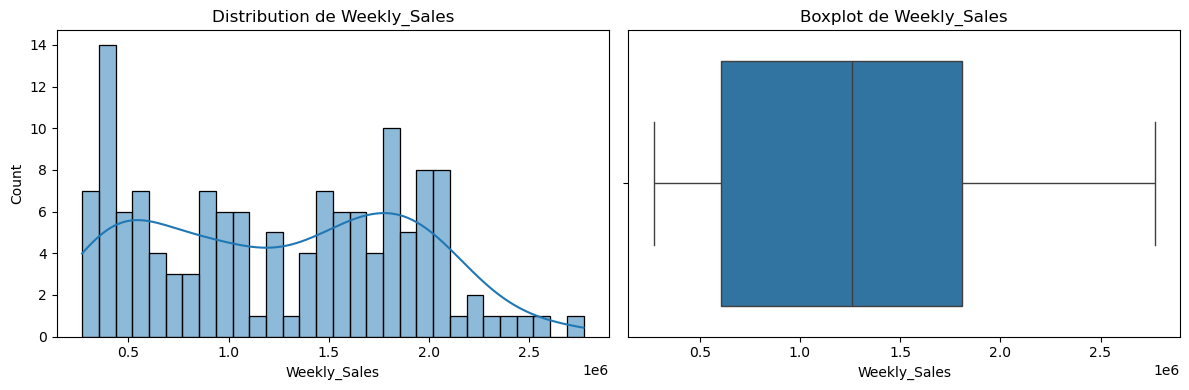

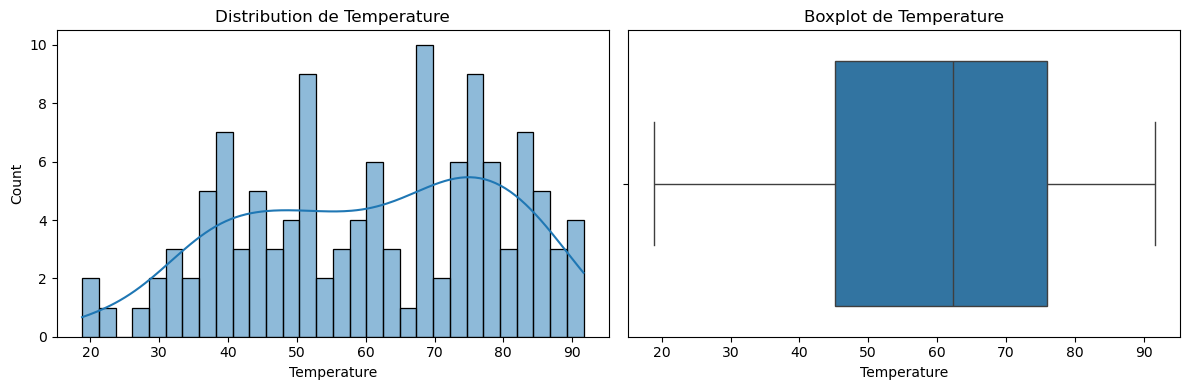

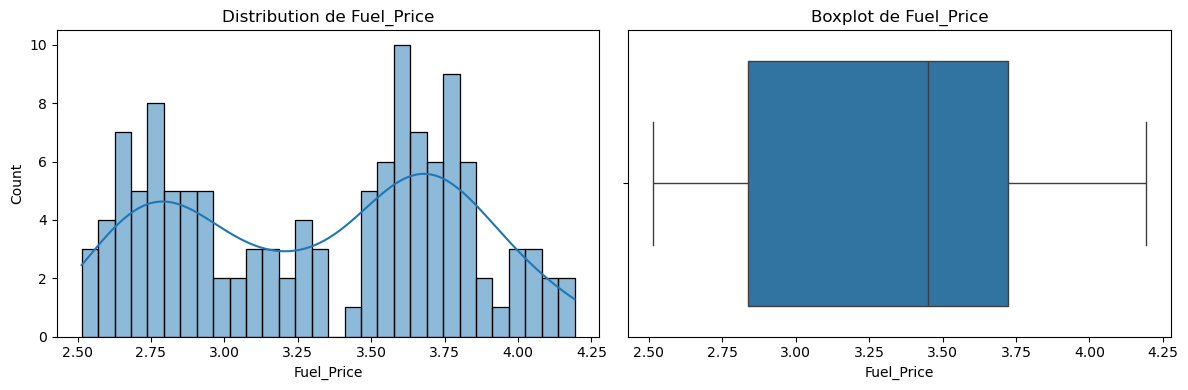

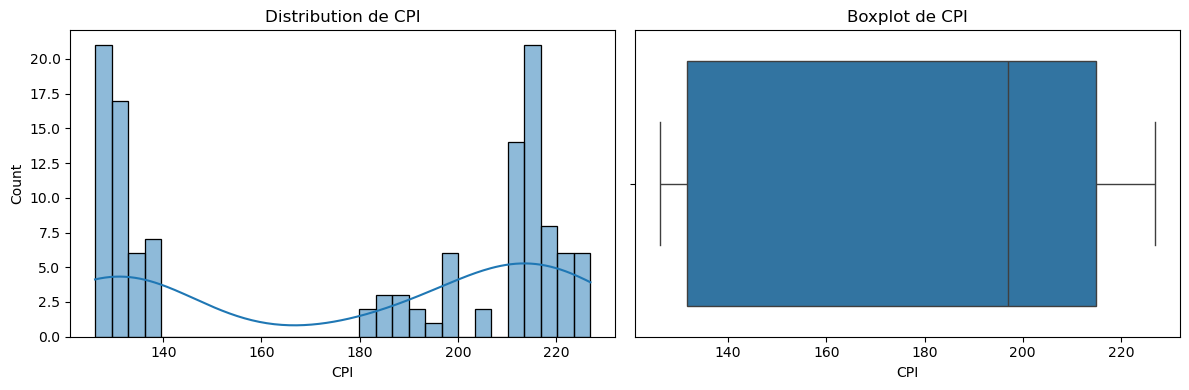

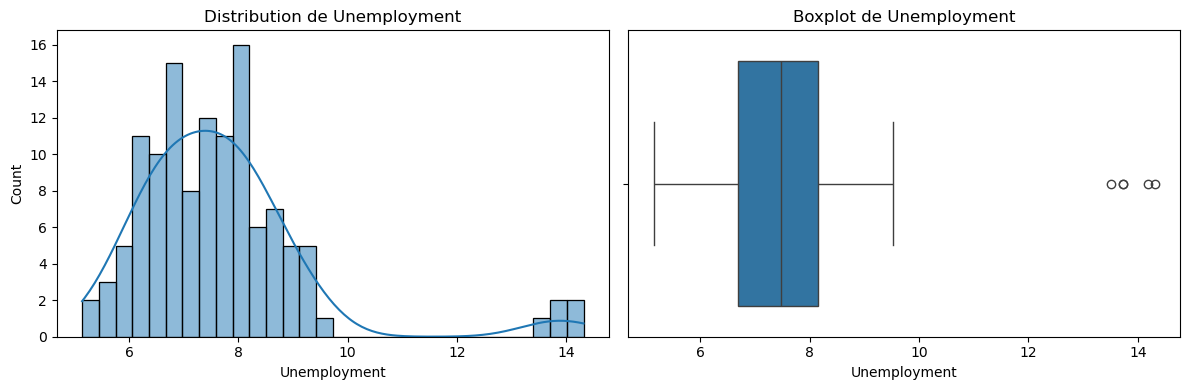

In [8]:
# Distribution of each numeric variable
num_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in num_features:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution de {col}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean[col])
    plt.title(f'Boxplot de {col}')

    plt.tight_layout()
    plt.show()

In [9]:
# Removing outliers from the 'Unemployment' column using the IQR method

# Calculate the first quartile (25th percentile)
Q1 = df_clean['Unemployment'].quantile(0.25)
# Calculate the third quartile (75th percentile)
Q3 = df_clean['Unemployment'].quantile(0.75)
# Compute the Interquartile Range (IQR = Q3 - Q1)
IQR = Q3 - Q1

# Define the lower bound (Q1 - 1.5 * IQR)
lower = Q1 - 1.5 * IQR
# Define the upper bound (Q3 + 1.5 * IQR)
upper = Q3 + 1.5 * IQR

# Keep only rows where 'Unemployment' values are within the bounds
# This removes values considered as outliers
df_clean = df_clean[(df_clean['Unemployment'] >= lower) & (df_clean['Unemployment'] <= upper)].copy()


#### c. Analyse bivariée

In [10]:
# Loop through all columns except the target
for col in df_clean.columns:
    if col == "Weekly_Sales":
        continue  # Skip plotting the target against itself
    
    # Create a scatter plot of the feature vs Weekly_Sales
    # Add a marginal histogram on the X-axis to show the distribution
    fig = px.scatter(
        df_clean,
        x=col,
        y="Weekly_Sales",
        width=800,
        height=350,
        marginal_x="histogram",
        title=f"Relation entre {col} et Weekly_Sales (Scatter plot + Histogramme)"
    )
    
    # Center the title 
    fig.update_layout(title={'x': 0.5})
    
    # Display the figure
    fig.show()


<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Analyse exploratoire des relations entre variables explicatives et Weekly_Sales
</span></center>
</br>
<div style="font-size:85%">

1. **Store vs Weekly_Sales**  
   - Certains magasins réalisent systématiquement des ventes plus élevées que d’autres.  
   - La variabilité inter-magasins est importante → l’effet *Store* constitue probablement un facteur explicatif clé et devra être conservé comme variable de segmentation.  

2. **Holiday_Flag vs Weekly_Sales**  
   - Peu de points avec *Holiday_Flag = 1* (jours fériés).  
   - Dans ces rares cas, les ventes sont variables, sans tendance claire. Toutefois, cette variable pourrait capter un effet ponctuel significatif à intégrer dans le modèle.  

3. **Temperature vs Weekly_Sales**  
   - Pas de corrélation linéaire claire entre température et ventes.  
   - Les ventes restent dispersées pour toutes les valeurs de température → impact probable limité, sauf interactions avec d’autres variables temporelles ou régionales.  

4. **Fuel_Price vs Weekly_Sales**  
   - Aucune tendance nette observée, forte dispersion.  
   - Le prix du carburant seul ne semble pas explicatif. Cependant, il pourrait interagir avec d’autres variables (ex. *Holiday*, *Store*) et sera à tester dans le modèle supervisé.  

5. **CPI vs Weekly_Sales**  
   - Présence de deux “groupes” distincts de *CPI* (autour de 130 et 210).  
   - À l’intérieur de chaque groupe, les ventes varient fortement. Cette structure suggère une segmentation possible de la donnée (clustering).  

6. **Unemployment vs Weekly_Sales**  
   - La majorité des observations se situent autour de 6–8 % de chômage.  
   - Quelques valeurs isolées apparaissent vers 14 %, sans relation simple visible → variable à faible pouvoir explicatif direct, mais potentiellement utile combinée avec d’autres indicateurs économiques.  

7. **Year / Month / Day_of_year vs Weekly_Sales**  
   - Effet temporel marqué : certains mois (notamment décembre) présentent des pics.  
   - Indices de saisonnalité annuelle et d’effet “mois” → variables temporelles pertinentes pour capter la composante saisonnière dans les modèles prédictifs.  

</div>


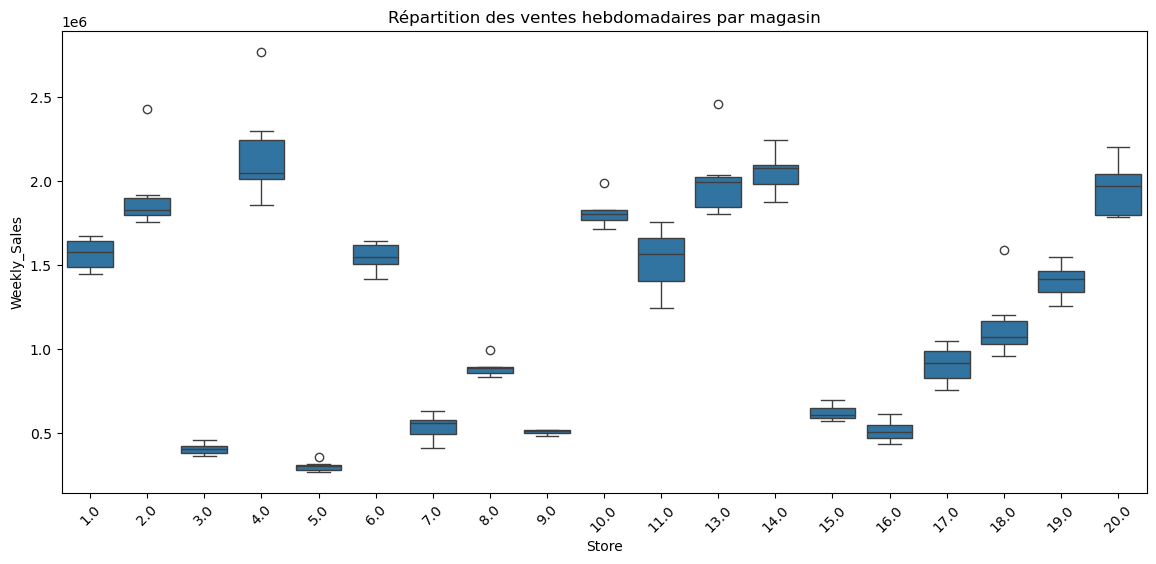

In [11]:
plt.figure(figsize=(14, 6))
# Create a boxplot to show the distribution of weekly sales for each store
sns.boxplot(x="Store", y="Weekly_Sales", data=df_clean)
# Add a descriptive title 
plt.title("Répartition des ventes hebdomadaires par magasin")
# Rotate x-axis labels to improve readability
plt.xticks(rotation=45)


# Display the final plot
plt.show()


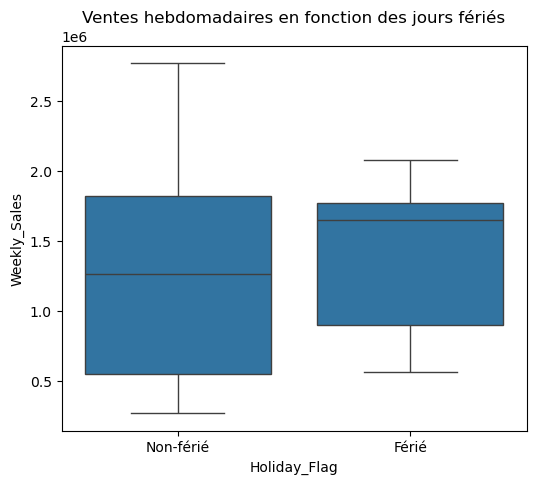

In [12]:
plt.figure(figsize=(6, 5))

# Create a boxplot to compare weekly sales depending on the holiday flag
sns.boxplot(x="Holiday_Flag", y="Weekly_Sales", data=df_clean)
plt.title("Ventes hebdomadaires en fonction des jours fériés")

# Customize x-axis tick labels: 0 = Non-holiday, 1 = Holiday
plt.xticks([0, 1], ["Non-férié", "Férié"])

# Display the final plot
plt.show()


<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Commentaires sur les boxplots
</span></center>
</br>
<div style="font-size:85%">

1. **Répartition des ventes hebdomadaires par magasin**  
   - Les ventes varient fortement selon les magasins.  
   - Certains magasins présentent systématiquement des ventes plus élevées que d’autres.  
   - L’effet *Store* semble donc être un facteur explicatif clé.  

2. **Ventes hebdomadaires en fonction des jours fériés**  
   - Peu d’observations en période de jours fériés (*Holiday_Flag = 1*).  
   - Les ventes peuvent être légèrement plus faibles ou similaires aux périodes normales, sans tendance claire et marquée.  

</div>

#### d. Analyse multivariée

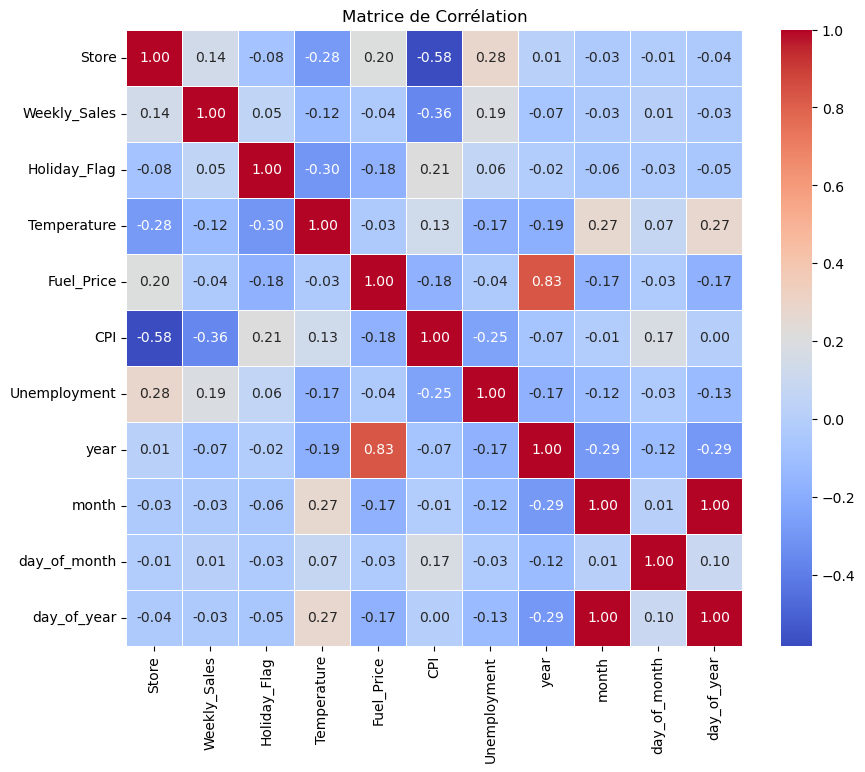

In [13]:
# Compute and visualize the correlation matrix for all numeric variables
numeric_cols = df_clean.select_dtypes(include='number').columns
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()


<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Décisions de features (alignées avec le heatmap)
</span></center>
</br>
<div style="font-size:85%">
 
- `day_of_year` est redondant avec la saisonnalité déjà capturée par `month` et `day_of_month` → **supprimé**.  
- `year` est fortement corrélé à `Fuel_Price` (≈ 0,83) et reflète surtout une **tendance temporelle**.  
  Comme `year` n’améliore pas les performances en CV (R² inchangé/légèrement moindre), nous **retirons `year`** et conservons `Fuel_Price` comme **proxy de tendance** afin de **réduire la multicolinéarité**.  
- `month` et `day_of_month` sont conservés pour la **saisonnalité**.  

</div>


In [14]:
# Drop redundant temporal features to reduce multicollinearity
# inplace=True applies the change directly to df_clean (no new DataFrame returned)
df_clean.drop(columns=['day_of_year'], inplace=True)
df_clean.drop(columns=['year'], inplace=True)

## II. Preprocessing

In [15]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "month", "day_of_month"]
target_variable = "Weekly_Sales"

X = df_clean.loc[:,features_list]
Y = df_clean.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
3   11.0           0.0        84.57         NaN  214.556497         7.346   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
5    4.0           0.0          NaN       2.756  126.160226         7.896   

   month  day_of_month  
0    2.0          18.0  
1    3.0          25.0  
3    NaN           NaN  
4    5.0          28.0  
5    5.0          28.0  


In [16]:
numeric_features = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price']
categorical_features = ['Store', 'Holiday_Flag', 'month', 'day_of_month']

In [17]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [18]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [19]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
    drop='first',              # Drop the first category of each feature to avoid dummy variable trap (perfect collinearity).
    handle_unknown='ignore',   # Ignore any unseen categories during transform (instead of raising an error).
    sparse_output=False        # Return a dense NumPy array instead of a sparse matrix (useful if combining with models that don't handle sparse input).
))
    ])

In [20]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Métriques utilisées
</span></center>
</br>
<div style="font-size:85%">

- **R² (coefficient de détermination)**  
  Mesure la proportion de la variance expliquée par le modèle.  
  → Proche de 1 : bonne explication ; proche de 0 : pas mieux qu’une moyenne.  
  *Note : R² peut être négatif sur le test si le modèle généralise mal.*

- **MAE (Mean Absolute Error)**  
  Moyenne des écarts absolus entre valeurs réelles et prédites.  
  → Interprétation directe dans l’unité de la cible (ventes hebdomadaires).

- **RMSE (Root Mean Squared Error)**  
  Racine de la moyenne des erreurs au carré.  
  → Pénalise davantage les grosses erreurs (outliers).  
  *Toujours ≥ MAE ; un grand écart RMSE–MAE indique des erreurs extrêmes.*

- **MAPE (Mean Absolute Percentage Error)**  
  Erreur absolue moyenne en **%** des valeurs réelles.  
  → Pratique pour comparer entre segments/échelles.  
  *Sensible aux petites valeurs de la cible (division par de petits y).*

- **Validation croisée (Cross-Validation, CV)**  
  Découpage en *k* « folds » ; on entraîne sur *k−1* et on valide sur le fold restant (rotation).  
  → Estimation **plus robuste** qu’un seul split.  
  *On rapporte la moyenne et l’écart-type des scores CV, puis une évaluation finale sur un hold-out test séparé.*

</div>


### Modèles

In [21]:
# Define 7-fold Cross-Validation
# - shuffle=True makes folds randomized
# - random_state ensures reproducibility
cv10 = KFold(n_splits=10, shuffle=True, random_state=42)

In [22]:
#Define custom RMSE scorer
#- By default sklearn only has negative MSE/MAE
rmse_scorer = make_scorer(
    lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)),
    greater_is_better=False
)

#### a. Régression linéaire

In [23]:
# Create pipeline: preprocessing + Linear Regression model
pipe = Pipeline([
    ("preprocess", preprocessor),       
    ("model", LinearRegression())       
])

In [ ]:
# Run cross-validation on training data 
cv_scores = cross_validate(
    pipe,                # pipeline = preprocessing + model
    X_train, y_train,   
    cv=cv10,            
    scoring={            # metrics to evaluate at each fold
        "r2": "r2",                          # R² (coefficient of determination)
        "mae": "neg_mean_absolute_error",    # MAE (returned as negative by sklearn)
        "rmse": rmse_scorer                  
    },
    return_train_score=True,  # also return training scores for each fold (to check overfitting)
    n_jobs=-1                 # use all CPU cores for parallel processing
)

# Summarize CV results 
cv_summary = pd.DataFrame({
    "R2_train_mean": [cv_scores["train_r2"].mean()],     
    "R2_val_mean":   [cv_scores["test_r2"].mean()],      
    "MAE_val_mean":  [-cv_scores["test_mae"].mean()],    
    "RMSE_val_mean": [-cv_scores["test_rmse"].mean()],   
})

print(cv_summary.round(3))  


In [ ]:
# Fit final model on training set
pipe.fit(X_train, y_train)

# Evaluation on training set 
y_train_pred = pipe.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Evaluation on test set (hold-out data) 
y_test_pred = pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2   = r2_score(y_test, y_test_pred)

# Print results 
print(f"Train R² : {r2_train:.3f}")
print(f"Test MAE : {mae:,.2f}")
print(f"Test RMSE: {rmse:,.2f}")
print(f"Test R²  : {r2:.3f}")


Train R² : 0.997
Test MAE : 119,722.28
Test RMSE: 145,446.89
Test R²  : 0.954


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Interprétation des résultats 
</span></center>
</br>
<div style="font-size:85%">

1. Choix de l’algorithme  
Une approche **supervisée** a été retenue (variable cible `Weekly_Sales` continue).  
La **régression linéaire** a été choisie comme modèle de référence, pour sa simplicité et son interprétabilité.  

2. Pipeline de préparation  
- Numériques : imputation par médiane + standardisation.  
- Catégorielles : imputation par valeur la plus fréquente + encodage OneHotEncoder (drop='first').  

3. Validation croisée (10 folds)  
Résultats moyens : R² train = 0.997, R² val = 0.897, MAE ≈ 120k, RMSE ≈ 156k.  
→ Le modèle explique environ **90% de la variance** en validation, avec un léger surapprentissage mais une bonne robustesse.  

4. Évaluation finale (jeu de test, 20%)  
Résultats : R² = 0.954, MAE ≈ 120k, RMSE ≈ 145k.  
→ Sur données nouvelles, le modèle explique **95% de la variance** avec des erreurs contenues au regard des ventes (>1M).  

**Conclusion :**  
Le modèle est **robuste et généralisable**. Il offre des prévisions fiables, confirmées par le test final.  
En perspective, l’usage de **Ridge/Lasso** permettrait de réduire l’éventuel surapprentissage et d’analyser l’importance des variables.  

</div>


In [ ]:
# Compute residuals (errors)
errors = y_test - y_test_pred      # true - predicted
abs_errors = np.abs(errors)

# Create a DataFrame with useful info
df_errors = pd.DataFrame({
    "y_true": y_test,        
    "y_pred": y_test_pred,   
    "error": errors,         # residuals (true - pred)
    "abs_error": abs_errors  # absolute residuals
})

# Sort by largest absolute error
df_errors_sorted = df_errors.sort_values(by="abs_error", ascending=False)

# Show the 10 worst errors
print(df_errors_sorted.head(10))

         y_true        y_pred          error      abs_error
29   1420405.41  1.789275e+06 -368869.581768  368869.581768
145  2248645.59  1.980501e+06  268144.472067  268144.472067
103  2302504.86  2.521066e+06 -218561.293571  218561.293571
82   1569607.94  1.351291e+06  218316.592429  218316.592429
13   1677472.78  1.496070e+06  181402.509184  181402.509184
12    414094.05  5.942947e+05 -180200.611663  180200.611663
14    829207.27  9.708513e+05 -141644.028331  141644.028331
61   1990371.02  1.858850e+06  131521.494264  131521.494264
116   457340.06  3.338166e+05  123523.478078  123523.478078
50   2035431.39  2.153428e+06 -117996.187652  117996.187652


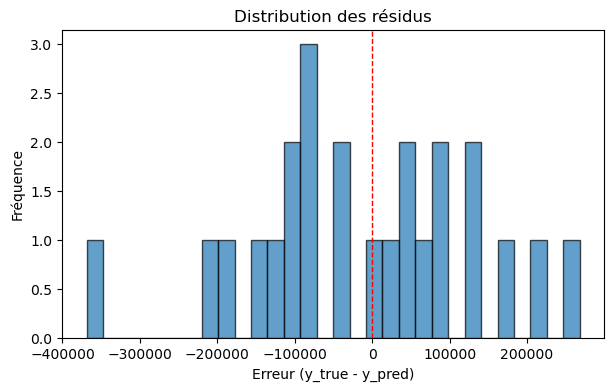

In [ ]:
# Plot a histogram of residuals to check their distribution
plt.figure(figsize=(7,4))
# Residuals histogram: higher bins = more residuals in that range
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
# Add a vertical line at zero to see if residuals are centered
plt.axvline(0, linestyle='--', linewidth=1, color='r')

plt.title("Distribution des résidus")
plt.xlabel("Erreur (y_true - y_pred)")
plt.ylabel("Fréquence")
plt.show()

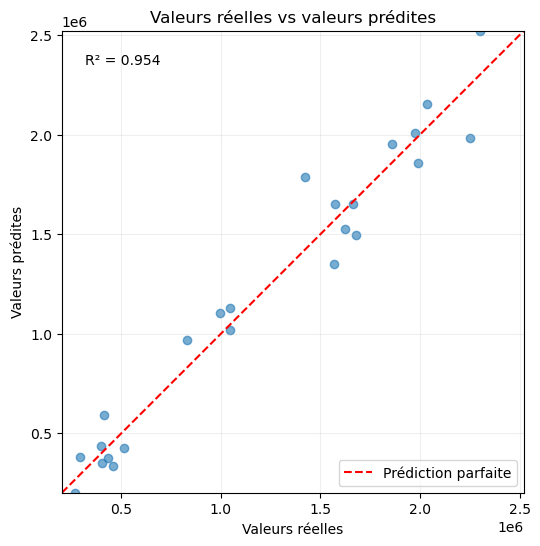

In [ ]:
# Scatter plot to compare true vs. predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6)

# Compute common limits so the identity line covers the whole cloud
lim_min = min(y_test.min(), y_test_pred.min())
lim_max = max(y_test.max(), y_test_pred.max())

# 45° identity line (perfect predictions lie on this line)
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', label='Prédiction parfaite')

# Make axes comparable and add basic labels
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(lim_min, lim_max)
plt.ylim(lim_min, lim_max)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Valeurs réelles vs valeurs prédites")
plt.legend(loc="lower right")

# Show R² on the plot
r2 = r2_score(y_test, y_test_pred)
plt.text(0.05, 0.95, f"R² = {r2:.3f}", transform=plt.gca().transAxes, va='top')

plt.grid(alpha=0.2)
plt.show()


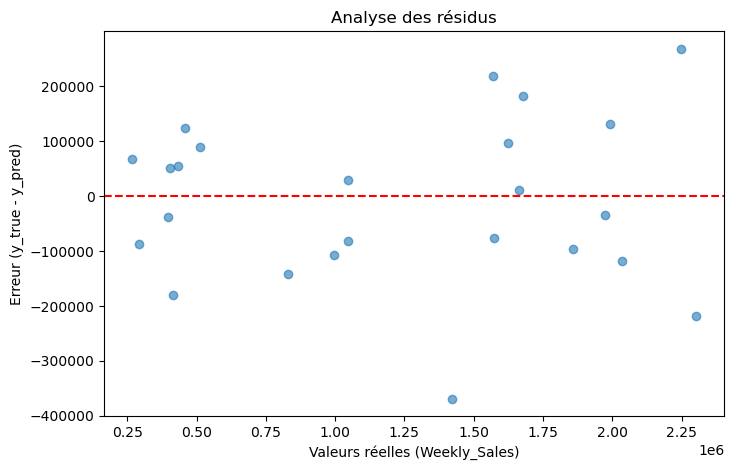

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, errors, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs réelles (Weekly_Sales)")
plt.ylabel("Erreur (y_true - y_pred)")
plt.title("Analyse des résidus")
plt.show()

<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Analyse des résidus
</span></center>
</br>
<div style="font-size:85%">

- La distribution des résidus est centrée autour de zéro, ce qui confirme l’absence de biais systématique : le modèle ne surestime ni ne sous-estime globalement les ventes.  
- Le graphique des valeurs réelles vs. prédites montre que les points suivent bien la diagonale, signe que le modèle capture correctement la tendance générale.  
- Toutefois, les résidus présentent une dispersion importante, notamment pour des ventes très élevées (> 1.5M), ce qui traduit une difficulté à prédire les cas extrêmes (effet d’hétéroscédasticité).  
- La différence entre MAE (~120k) et RMSE (~145k) confirme la présence de quelques erreurs fortes, liées à des observations atypiques ou difficiles à modéliser.  

Pour renforcer la robustesse et réduire l’impact de ces écarts importants, il serait pertinent d’explorer des méthodes de régularisation comme **Ridge** et **Lasso**, qui permettent de limiter le surapprentissage et de mieux gérer la contribution des variables.  

</div>

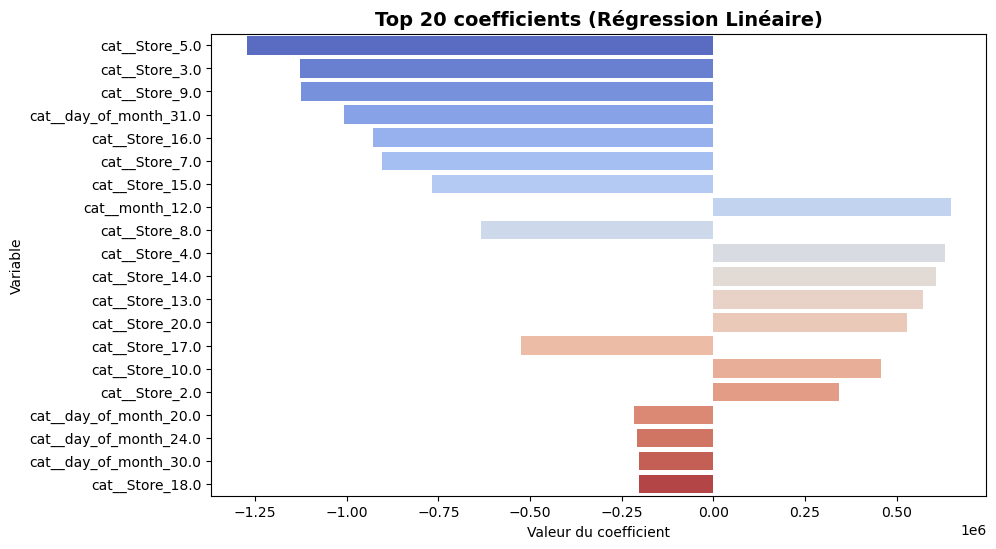

In [ ]:
# Extract model coefficients (after fitting)
coefficients = pipe.named_steps["model"].coef_
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()

# Put into a DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

top_n = 20
coef_df_sorted = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10,6))
sns.barplot(
    x="Coefficient", 
    y="Feature", 
    data=coef_df_sorted.head(20), 
    hue="Feature", 
    palette="coolwarm", 
    dodge=False, 
    legend=False
)
plt.title("Top 20 coefficients (Régression Linéaire)", fontsize=14, weight="bold")
plt.xlabel("Valeur du coefficient")
plt.ylabel("Variable")
plt.show()



<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Interprétation des coefficients
</span></center>
</br>
<div style="font-size:85%">

L’analyse des coefficients de la régression linéaire met en évidence que certaines variables catégorielles, notamment l’identifiant du magasin (Store), jouent un rôle majeur dans la prédiction des ventes hebdomadaires. Certains magasins (par ex. Store 5, Store 3, Store 9) sont fortement associés à des variations positives ou négatives des ventes, ce qui traduit des différences structurelles importantes entre points de vente.

De plus, certaines variables temporelles comme le mois ou le jour du mois apparaissent également dans le top 20, suggérant un effet saisonnier ou calendaire sur les ventes.

En revanche, les variables continues telles que CPI, Fuel_Price ou Unemployment n’apparaissent pas parmi les coefficients les plus influents, ce qui indique qu’elles expliquent moins directement la variance des ventes.

Globalement, cela confirme que la localisation (Store) et la dimension temporelle sont des déterminants majeurs du modèle.
</div>

#### b. Ridge (Régularisation L2)

In [ ]:
# Pipeline: preprocessing + Ridge
pipe_ridge = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(random_state=42))
])

# Grid of alphas 
param_grid = {"model__alpha": [0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]}

# GridSearchCV 
ridge_cv = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid,
    scoring="r2",
    cv=cv10,
    n_jobs=-1
)

ridge_cv.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_cv.best_params_["model__alpha"])
print("Best CV R²:", ridge_cv.best_score_)

best_ridge = ridge_cv.best_estimator_

# Prédictions
y_train_pred_ridge = best_ridge.predict(X_train)
y_test_pred_ridge  = best_ridge.predict(X_test)

# Métriques
print(f"Ridge Train R² : {r2_score(y_train, y_train_pred_ridge):.3f}")
print(f"Ridge Test  R² : {r2_score(y_test,  y_test_pred_ridge):.3f}")
print(f"Ridge Test MAE : {mean_absolute_error(y_test, y_test_pred_ridge):,.0f}")
print(f"Ridge Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)):,.0f}")

Best Ridge alpha: 0.01
Best CV R²: 0.9183180793497849
Ridge Train R² : 0.996
Ridge Test  R² : 0.954
Ridge Test MAE : 119,284
Ridge Test RMSE: 145,348


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



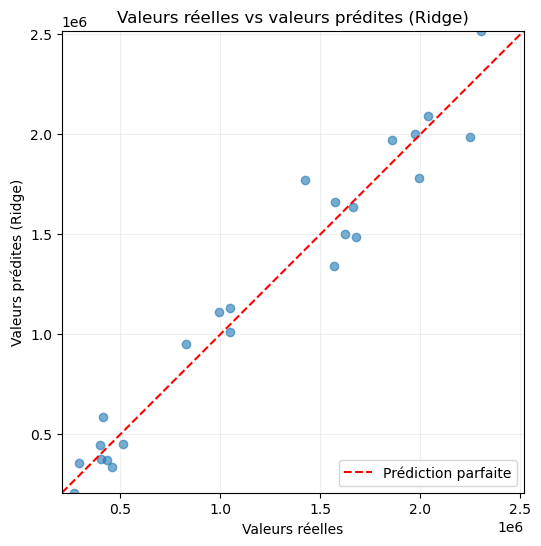

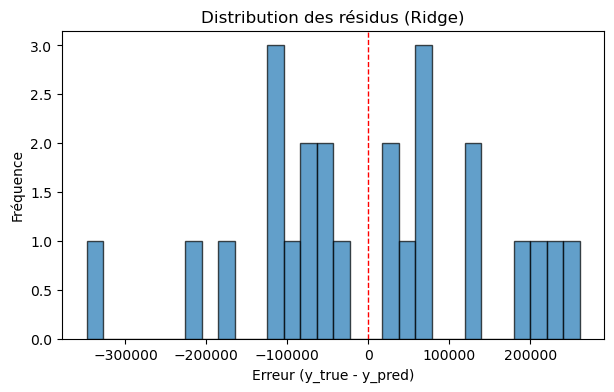

In [ ]:
# Residuals on the held-out test set 
# Residuals = true - predicted; centered around 0 if the model is unbiased
res_ridge = y_test - y_test_pred_ridge

# True vs. Predicted (Ridge)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_ridge, alpha=0.6)
lim_min = min(y_test.min(), y_test_pred_ridge.min())
lim_max = max(y_test.max(), y_test_pred_ridge.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', label='Prédiction parfaite')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(lim_min, lim_max); plt.ylim(lim_min, lim_max)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites (Ridge)")
plt.title("Valeurs réelles vs valeurs prédites (Ridge)")
plt.legend(loc="lower right"); plt.grid(alpha=0.2); plt.show()


# Residuals histogram (Ridge)
plt.figure(figsize=(7,4))
plt.hist(res_ridge, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, linestyle='--', linewidth=1, color='r')
plt.title("Distribution des résidus (Ridge)")
plt.xlabel("Erreur (y_true - y_pred)")
plt.ylabel("Fréquence")
plt.show()

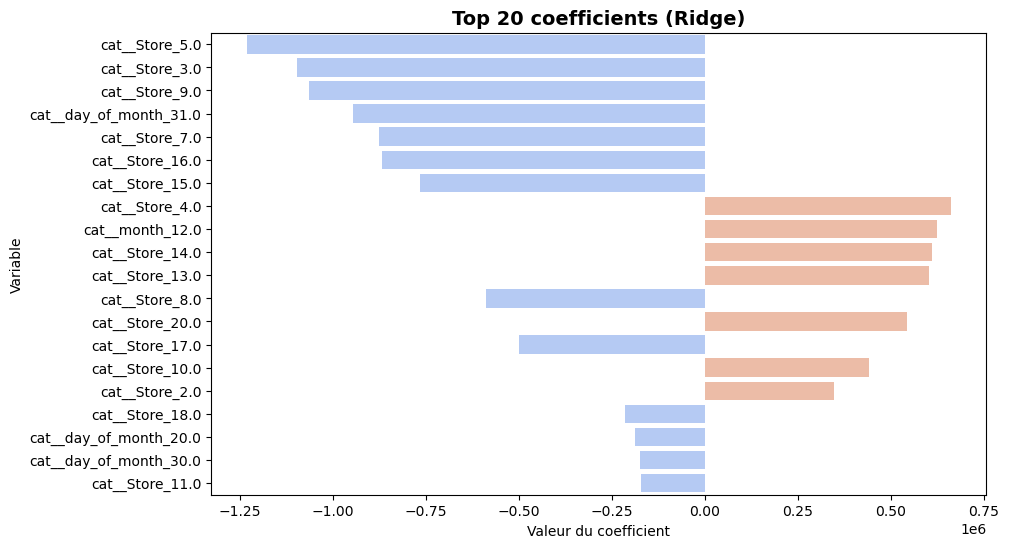

In [ ]:
feature_names_ridge = best_ridge.named_steps["preprocess"].get_feature_names_out()
coefficients_ridge = best_ridge.named_steps["model"].coef_

coef_df_ridge = (
    pd.DataFrame({"Variable": feature_names_ridge, "Coefficient": coefficients_ridge})
      .reindex(np.abs(coefficients_ridge).argsort()[::-1])  
)

top_ridge = coef_df_ridge.head(top_n).copy()
top_ridge["Effet"] = np.where(top_ridge["Coefficient"] >= 0, "Positif", "Négatif")

# Graph
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_ridge,
    x="Coefficient",
    y="Variable",
    hue="Effet",         
    dodge=False,
    palette="coolwarm",
    legend=False
)
plt.title(f"Top {top_n} coefficients (Ridge)", fontsize=14, weight="bold")
plt.xlabel("Valeur du coefficient")
plt.ylabel("Variable")
plt.show()


#### c. Lasso (Régularisation L1)

In [ ]:
# Pipeline + GridSearchCV (Lasso)

pipe_lasso = Pipeline([
    ("preprocess", preprocessor),
    ("model", Lasso(max_iter=10000))  
])

param_grid = {"model__alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 300, 400, 450, 500, 550]}

lasso_cv = GridSearchCV(
    estimator=pipe_lasso,
    param_grid=param_grid,
    scoring="r2",
    cv=cv10,
    n_jobs=-1
)

lasso_cv.fit(X_train, y_train)
print("Best Lasso alpha:", lasso_cv.best_params_["model__alpha"])
print("Best CV R²:", lasso_cv.best_score_)

Best Lasso alpha: 450
Best CV R²: 0.9407262988243262


In [ ]:
# Evaluation train/test
best_lasso = lasso_cv.best_estimator_  

y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso  = best_lasso.predict(X_test)

print(f"Lasso Train R² : {r2_score(y_train, y_train_pred_lasso):.3f}")
print(f"Lasso Test  R² : {r2_score(y_test,  y_test_pred_lasso):.3f}")
print(f"Lasso Test MAE : {mean_absolute_error(y_test, y_test_pred_lasso):,.0f}")
print(f"Lasso Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)):,.0f}")

Lasso Train R² : 0.994
Lasso Test  R² : 0.950
Lasso Test MAE : 119,094
Lasso Test RMSE: 150,965


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



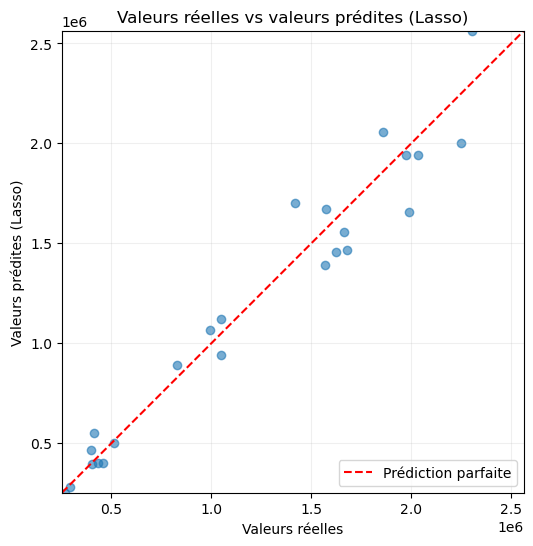

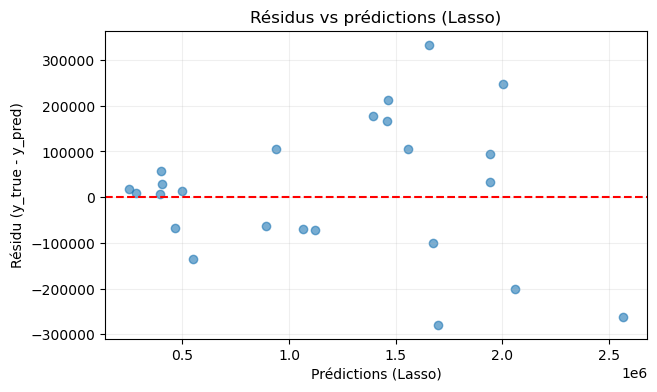

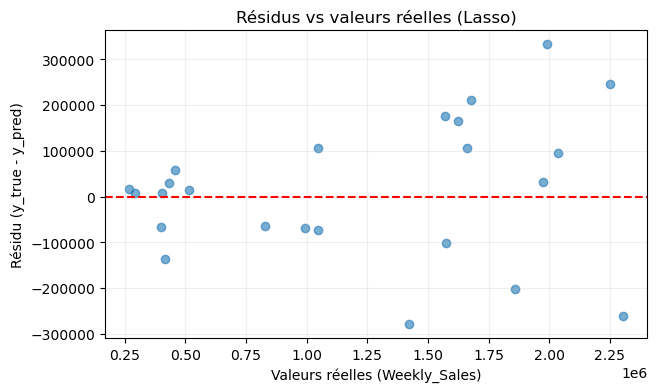

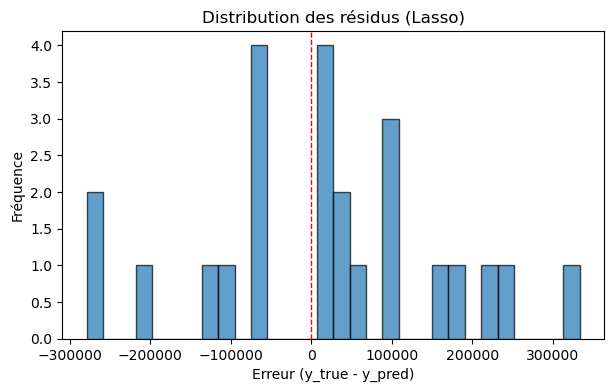

In [ ]:
# Residuals Analysis (test) 

# Compute residuals on the held-out test set (positive = under-prediction)
res_lasso = y_test - y_test_pred_lasso

# (a) True vs. Predicted scatter — check overall fit against 45° identity line
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_lasso, alpha=0.6)

# Use common limits so the identity line spans the whole cloud
lim_min = min(y_test.min(), y_test_pred_lasso.min())
lim_max = max(y_test.max(), y_test_pred_lasso.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', label='Prédiction parfaite')

# Make axes comparable and add basic formatting
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(lim_min, lim_max); plt.ylim(lim_min, lim_max)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites (Lasso)")
plt.title("Valeurs réelles vs valeurs prédites (Lasso)")
plt.legend(loc="lower right"); plt.grid(alpha=0.2); plt.show()

# (b) Residuals vs. Predictions — check for patterns/bias across prediction scale
plt.figure(figsize=(7,4))
plt.scatter(y_test_pred_lasso, res_lasso, alpha=0.6)
plt.axhline(0, ls="--", c="r")  # zero line: unbiased residuals should be centered here
plt.xlabel("Prédictions (Lasso)")
plt.ylabel("Résidu (y_true - y_pred)")
plt.title("Résidus vs prédictions (Lasso)")
plt.grid(alpha=0.2); plt.show()

# (c) Residuals vs. True values — look for heteroscedasticity at high sales levels
plt.figure(figsize=(7,4))
plt.scatter(y_test, res_lasso, alpha=0.6)
plt.axhline(0, ls="--", c="r")
plt.xlabel("Valeurs réelles (Weekly_Sales)")
plt.ylabel("Résidu (y_true - y_pred)")
plt.title("Résidus vs valeurs réelles (Lasso)")
plt.grid(alpha=0.2); plt.show()

# (d) Residuals histogram — assess centering and tail heaviness
plt.figure(figsize=(7,4))
plt.hist(res_lasso, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, linestyle='--', linewidth=1, color='r')  # helps assess centering at zero
plt.title("Distribution des résidus (Lasso)")
plt.xlabel("Erreur (y_true - y_pred)")
plt.ylabel("Fréquence")
plt.show()

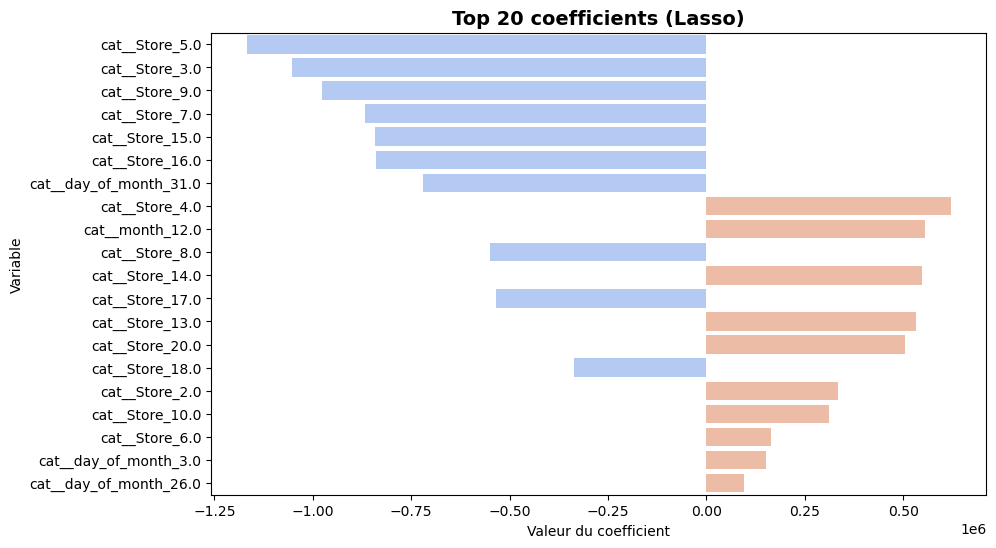

In [ ]:
# Top coefficients (interpretation) 

# Get feature names after preprocessing and the fitted Lasso coefficients
feature_names_lasso = best_lasso.named_steps["preprocess"].get_feature_names_out()
coefficients_lasso  = best_lasso.named_steps["model"].coef_

# Build a DataFrame and sort by absolute coefficient magnitude (largest first)
coef_df_lasso = (pd.DataFrame({"Variable": feature_names_lasso, "Coefficient": coefficients_lasso})
                 .reindex(np.abs(coefficients_lasso).argsort()[::-1]))

# Keep only the Top-N most influential coefficients for readability
top_lasso = coef_df_lasso.head(top_n).copy()

# Tag coefficient sign to color bars (positive vs negative)
top_lasso["Effet"] = np.where(top_lasso["Coefficient"] >= 0, "Positif", "Négatif")

# Plot horizontal bar chart 
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_lasso,
    x="Coefficient",
    y="Variable",
    hue="Effet",          
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.title(f"Top {top_n} coefficients (Lasso)", fontsize=14, weight="bold")
plt.xlabel("Valeur du coefficient")
plt.ylabel("Variable")
plt.show()


In [ ]:
# Hyperparameter grid for Lasso: 30 values logarithmically spaced from 1e-4 to 1e2
alphas = np.logspace(-4, 2, 30)

# Build a single, leak-free pipeline:
#  - preprocess: imputation/scaling/OHE (learned ONLY on training folds)
#  - select: L1-based feature selection with LassoCV (alpha chosen by CV inside the pipeline)
#  - reg: final LassoCV regressor (alpha chosen by CV inside the pipeline)
pipe_fs_auto = Pipeline([
    ("preprocess", preprocessor),
    ("select", SelectFromModel(
        estimator=LassoCV(alphas=alphas, cv=cv10, max_iter=50000),
        threshold="mean"   # keep features with |coef| above the mean |coef| (roughly ~50% of strongest effects)
    )),
    ("reg", LassoCV(alphas=alphas, cv=cv10, max_iter=50000))
])

# Fit the whole pipeline on the training set.
# Note: both the selector and the final regressor pick their alphas via CV internally,
# and all steps are refit properly without data leakage.
pipe_fs_auto.fit(X_train, y_train)

# Predict on train/test to evaluate generalization
y_train_pred = pipe_fs_auto.predict(X_train)
y_test_pred  = pipe_fs_auto.predict(X_test)

# Report standard metrics
print(f"Train R² : {r2_score(y_train, y_train_pred):.3f}")
print(f"Test  R² : {r2_score(y_test,  y_test_pred):.3f}")
print(f"Test MAE : {mean_absolute_error(y_test, y_test_pred):,.0f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):,.0f}")

# Retrieve post-preprocessing feature names (after OHE, scaling, etc.)
feat_names = pipe_fs_auto.named_steps["preprocess"].get_feature_names_out()

# Boolean mask of selected features from the SelectFromModel step
mask = pipe_fs_auto.named_steps["select"].get_support()

# Count (and later list) of the selected features
print("Features sélectionnées:", int(mask.sum()))

selected_features = np.array(feat_names)[mask]
print(selected_features.tolist())


Train R² : 0.982
Test  R² : 0.956
Test MAE : 112,010
Test RMSE: 142,942
Features sélectionnées: 17
['cat__Store_2.0', 'cat__Store_3.0', 'cat__Store_4.0', 'cat__Store_5.0', 'cat__Store_7.0', 'cat__Store_8.0', 'cat__Store_9.0', 'cat__Store_10.0', 'cat__Store_13.0', 'cat__Store_14.0', 'cat__Store_15.0', 'cat__Store_16.0', 'cat__Store_17.0', 'cat__Store_18.0', 'cat__Store_20.0', 'cat__month_12.0', 'cat__day_of_month_31.0']


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



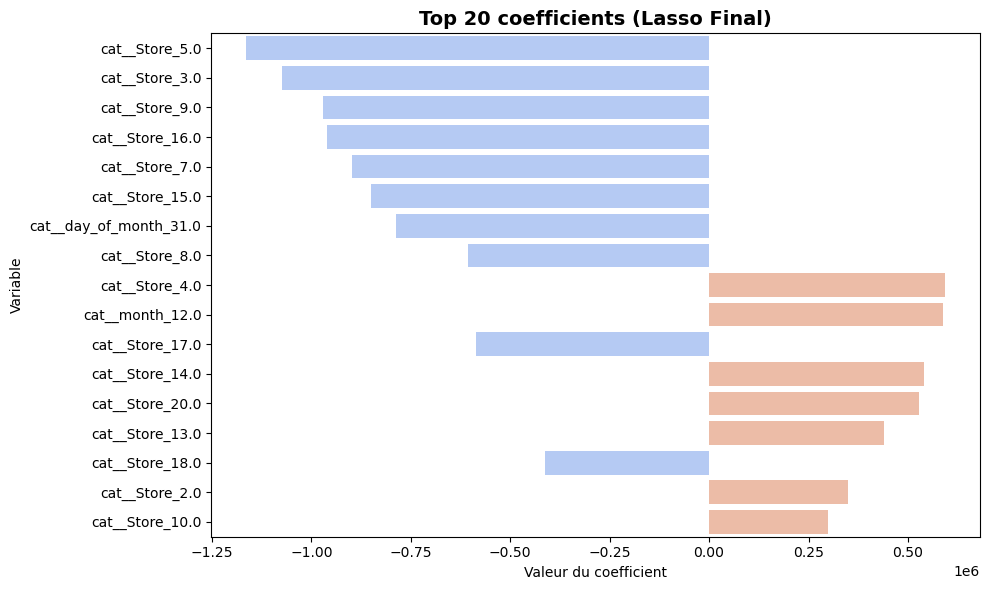

In [ ]:
final_coefs = pipe_fs_auto.named_steps["reg"].coef_
coef_df = (pd.DataFrame({"Variable": selected_features, "Coefficient": final_coefs})
           .reindex(np.abs(final_coefs).argsort()[::-1]))
coef_df["Effet"] = np.where(coef_df["Coefficient"] >= 0, "Positif", "Négatif")

top_n = 20
plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.head(top_n),
    x="Coefficient", y="Variable",
    hue="Effet", palette="coolwarm",
    dodge=False, legend=False   
)
plt.title(f"Top {top_n} coefficients (Lasso Final)", fontsize=14, weight="bold")
plt.xlabel("Valeur du coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


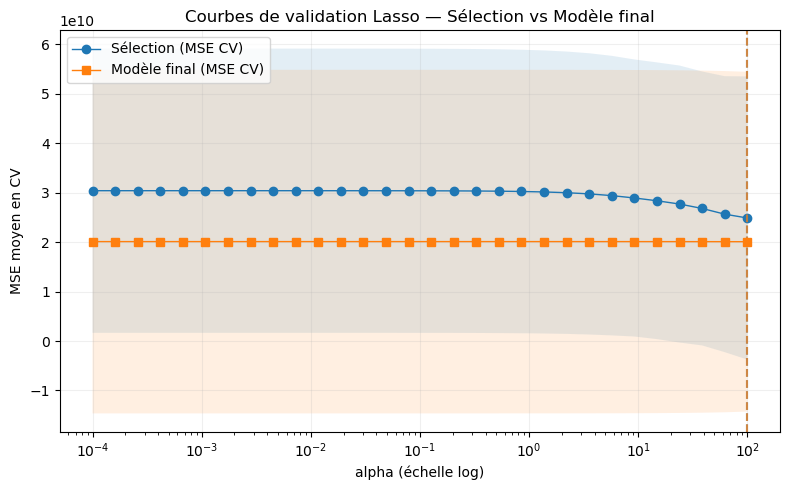

In [ ]:
# Retrieve the two LassoCV objects already fitted inside the pipeline 
sel_cv = pipe_fs_auto.named_steps["select"].estimator_  # LassoCV used by SelectFromModel (feature selector)
reg_cv = pipe_fs_auto.named_steps["reg"]                # LassoCV used as the final regressor

# Validation info for the selector 
# alphas_ : grid of tested alphas
# mse_path_ : per-fold MSE along the alpha grid (shape = [n_alphas, n_folds])
alphas_sel = sel_cv.alphas_
mse_sel    = sel_cv.mse_path_.mean(axis=1)   # mean CV MSE across folds for each alpha
std_sel    = sel_cv.mse_path_.std(axis=1)    # std across folds (to draw uncertainty band)
best_sel   = sel_cv.alpha_                   # alpha chosen by LassoCV for the selector

# Validation info for the final model 
alphas_reg = reg_cv.alphas_
mse_reg    = reg_cv.mse_path_.mean(axis=1)   # mean CV MSE for each alpha
std_reg    = reg_cv.mse_path_.std(axis=1)    # std across folds
best_reg   = reg_cv.alpha_                   # alpha chosen by LassoCV for the final model

# Plot both validation curves on a log alpha axis 
plt.figure(figsize=(8,5))

# Selector curve + uncertainty band + vertical line at best alpha
plt.semilogx(alphas_sel, mse_sel, marker="o", lw=1, label="Sélection (MSE CV)")
plt.fill_between(alphas_sel, mse_sel - std_sel, mse_sel + std_sel, alpha=0.12)
plt.axvline(best_sel, ls="--", c="C0", alpha=0.7)

# Final model curve + uncertainty band + vertical line at best alpha
plt.semilogx(alphas_reg, mse_reg, marker="s", lw=1, label="Modèle final (MSE CV)")
plt.fill_between(alphas_reg, mse_reg - std_reg, mse_reg + std_reg, alpha=0.12)
plt.axvline(best_reg, ls="--", c="C1", alpha=0.7)

# Labels / styling
plt.xlabel("alpha (échelle log)")
plt.ylabel("MSE moyen en CV")
plt.title("Courbes de validation Lasso — Sélection vs Modèle final")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


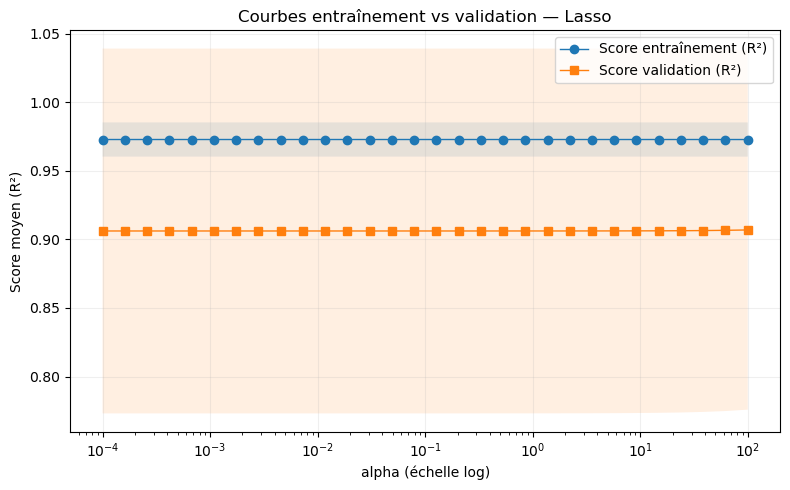

In [ ]:
alphas = np.logspace(-4, 2, 30)

pipe_for_vc = Pipeline([
    ("preprocess", preprocessor),
    ("select", pipe_fs_auto.named_steps["select"]),  # reuse the fitted selector's *definition*
    ("reg", Lasso(max_iter=50000))
])

# Validation curve on training data
train_scores, val_scores = validation_curve(
    estimator=pipe_for_vc,
    X=X_train, y=y_train,
    param_name="reg__alpha",
    param_range=alphas,
    cv=cv10,
    scoring="r2",                # or "neg_mean_squared_error"
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.semilogx(alphas, train_mean, marker="o", lw=1, label="Score entraînement (R²)")
plt.fill_between(alphas, train_mean-train_std, train_mean+train_std, alpha=0.12)
plt.semilogx(alphas, val_mean, marker="s", lw=1, label="Score validation (R²)")
plt.fill_between(alphas, val_mean-val_std, val_mean+val_std, alpha=0.12)
plt.xlabel("alpha (échelle log)")
plt.ylabel("Score moyen (R²)")
plt.title("Courbes entraînement vs validation — Lasso")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### III. Conclusions

In [ ]:
# Helper to evaluate a fitted estimator/pipeline on the current split.
def eval_model(estimator, name, *, cv_best=None, alpha=None, n_selected=None):
    """Compute train/test metrics for a fitted estimator (pipeline)."""
    # Predict on train and test
    y_tr = estimator.predict(X_train)
    y_te = estimator.predict(X_test)

    # Package results. 
    return {
        "Modèle": name,                     
        "α*": alpha,                          
        "CV R²": cv_best,                    
        "Train R²": r2_score(y_train, y_tr),  
        "Test R²":  r2_score(y_test,  y_te),  
        "Test MAE": mean_absolute_error(y_test, y_te),                
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_te)),       
        "# features sélectionnées": n_selected  
    }

rows = []

# Baseline: linear regression 
rows.append(eval_model(pipe, "Régression linéaire (baseline)"))

# Ridge: use the best estimator & best alpha chosen by GridSearchCV
ridge_best  = ridge_cv.best_estimator_                  
alpha_ridge = ridge_cv.best_params_.get("model__alpha", None)
rows.append(eval_model(
    ridge_best, "Ridge",
    cv_best=ridge_cv.best_score_,                       
    alpha=alpha_ridge
))

# Lasso: same idea with GridSearchCV for Lasso
lasso_best  = lasso_cv.best_estimator_
alpha_lasso = lasso_cv.best_params_.get("model__alpha", None)
rows.append(eval_model(
    lasso_best, "Lasso",
    cv_best=lasso_cv.best_score_,
    alpha=alpha_lasso
))

# Final pipeline: LassoCV for selection + LassoCV as final head ('pipe_fs_auto')
# Count selected features from SelectFromModel
n_sel = int(pipe_fs_auto.named_steps["select"].get_support().sum())
# Retrieve the alpha learned by the final LassoCV stage (attribute is alpha_)
alpha_final = getattr(pipe_fs_auto.named_steps["reg"], "alpha_", None)
rows.append(eval_model(
    pipe_fs_auto, "Lasso (sélection) + Lasso (final)",
    alpha=alpha_final, n_selected=n_sel
))

# Build the summary DataFrame (order columns explicitly)
df = pd.DataFrame(rows)[[
    "Modèle", "α*", "CV R²", "Train R²", "Test R²", "Test MAE", "Test RMSE", "# features sélectionnées"
]]

# Pretty display: format numbers and replace NaN with an em dash “—”
def fmt_r(x): 
    return "—" if pd.isna(x) else f"{x:.3f}"     # R² with 3 decimals
def fmt_e(x): 
    return "—" if pd.isna(x) else f"{x:,.0f}"    # errors with thousands separator, no decimals

display(
    df.style.format({
        "CV R²": fmt_r, "Train R²": fmt_r, "Test R²": fmt_r,
        "Test MAE": fmt_e, "Test RMSE": fmt_e,
        "α*": lambda x: "—" if pd.isna(x) else x,
        "# features sélectionnées": lambda x: "—" if pd.isna(x) else int(x),
    })
)


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



,Modèle,α*,CV R²,Train R²,Test R²,Test MAE,Test RMSE,# features sélectionnées
0,Régression linéaire (baseline),—,—,0.997,0.954,"119,722","145,447",—
1,Ridge,0.01,0.918,0.996,0.954,"119,284","145,348",—
2,Lasso,450.0,0.941,0.994,0.950,"119,094","150,965",—
3,Lasso (sélection) + Lasso (final),100.0,—,0.982,0.956,"112,010","142,942",17


<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Synthèse des modèles
</span></center>
</br>
<div style="font-size:85%">

- Tous les modèles expliquent ~**95 %** de la variance en test.
- **Meilleur compromis** : **Lasso (sélection) + Lasso (final)**  
  - **Test R² = 0.956** (meilleur), **MAE/RMSE** les plus bas.  
  - **17 variables** seulement → modèle **plus parcimonieux** et **plus interprétable**.  
  - Écart **Train–Test** plus faible (0.982 → 0.956), signe d’une **meilleure généralisation**.

- Ridge et la régression linéaire sont proches (R² test = 0.954) mais moins parsimonieux.
- Lasso seul a un **R² test plus bas** (0.950) et un **RMSE plus élevé**.

### Décision
**Retenir** le pipeline **Lasso (sélection) + Lasso (final, α≈100)** pour la production : précision supérieure **et** complexité réduite.

> *Note :* l’encodeur gère les catégories inconnues (warning « unknown categories ») en les encodant à 0 — comportement attendu avec `handle_unknown='ignore'`.
</div>


<center><span style="text-decoration:underline; text-decoration-thickness: 1px;
    text-underline-offset: 3px;">
Conclusion sur les coefficients des modèles
</span></center>
</br>
<div style="font-size:85%">

1) Signal commun et stable
- **Même histoire quel que soit le modèle** : les variables **Store_*** dominent très largement les coefficients, suivies par quelques **effets calendrier**
  (ex. **month_12** positif, **day_of_month_31** plutôt négatif).  
- Cette **stabilité** entre Linéaire → Ridge → Lasso → *Lasso final* indique que ces effets sont **robustes**.

2) Effet de la régularisation
- **Ridge**: réduit les amplitudes mais **conserve** presque tous les effets (aucun coefficient à 0). Bon lissage, moins de variance, mais **peu de parcimonie**.
- **Lasso**: **écrase à 0** de nombreux coefficients faibles → **sélection de variables**.  
- **Lasso final (après sélection)**: ne garde qu’un **sous-ensemble (≈17 features)**, essentiellement les **magasins majeurs** et **quelques effets calendrier**, ce qui
  **simplifie** fortement le modèle tout en **améliorant la généralisation** (meilleur R² test, MAE/RMSE plus bas).

3) Lecture métier (avec prudence méthodologique)
- Les **différences entre magasins** expliquent l’essentiel des ventes (effet “fixed store”).  
- Les **saisonnalités** existent (p. ex. **décembre** ↑), et quelques **jours du mois** ressortent.  
- **Attention à l’interprétation des magnitudes** :
  - Les **numériques** sont **standardisés** → un coefficient correspond à l’effet pour **+1 écart-type**.  
  - Les **catégorielles (One-Hot, drop='first')** se lisent **relativement à la catégorie de référence** (baseline).  
  - On ne compare pas naïvement l’ampleur *numérique vs catégorielle*.

4) Implications et limites
- Le modèle capte surtout des **spécificités locales de magasin**. Pour **de nouveaux stores** non vus, le one-hot tombe sur la **baseline** (warning
  “unknown categories → zeros”) : la **prédiction sera moins fiable**.  
- Pistes si besoin : regrouper les magasins (clusters), ajouter des **features structurelles** (surface, trafic, mix produit), tester des **interactions**
  (p. ex. *holiday × month*), ou un modèle **hiérarchique**.

**Décision** : le pipeline **Lasso (sélection) + Lasso (final)** est à privilégier :  
**interprétable, parcimonieux (17 variables), et le plus performant en test.**
</div>
